In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Runing on {str(device)}")

# Define dataset paths
data_dir = "./animals10"
torch_dataset_path = "./animals10DatasetNoNormalize.pt"

# Define class names
class_names = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)

# Load dataset from Torch tensor file
print("Loading dataset from Torch tensor file...")
data = torch.load(torch_dataset_path)
images, labels = data["images"], data["labels"]

dataset = TensorDataset(images, labels)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Runing on cuda
Loading dataset from Torch tensor file...


C:\Users\Hizan\AppData\Local\Temp\ipykernel_19668\1008683256.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(torch_dataset_path)


Train samples: 18325, Val samples: 3926, Test samples: 3928


In [3]:
transform = transforms.Compose([
    # If your images are not already 224×224, un-comment the following line:
    # transforms.Resize((224, 224)),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet mean
                         std=(0.229, 0.224, 0.225))   # ImageNet std
])

class NormalizedDataset(torch.utils.data.Dataset):
    """Wraps a dataset of (image_tensor, label) to apply transforms."""
    def __init__(self, wrapped_dataset, transform=None):
        self.wrapped_dataset = wrapped_dataset
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = self.wrapped_dataset[idx]
        # x is shape (3, H, W)
        if self.transform is not None:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.wrapped_dataset)

train_dataset = NormalizedDataset(train_dataset, transform=transform)
val_dataset   = NormalizedDataset(val_dataset, transform=transform)
test_dataset  = NormalizedDataset(test_dataset, transform=transform)

In [4]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (3, 224, 224) -> (32, 112, 112)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (32, 112, 112) -> (64, 56, 56)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (64, 56, 56) -> (128, 28, 28)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)               # extract features through conv layers
        x = x.view(x.size(0), -1)         # flatten for the classifier
        x = self.classifier(x)            # final classification
        return x

In [6]:

model = SimpleCNN(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust as needed

epochs = 10

In [7]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training/validation loss and accuracy curves in separate charts.
    """
    # Plot loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.show()

In [8]:
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item() * images_batch.size(0)
        
        # Compute training accuracy
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels_batch).sum().item()
        total += labels_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            
            # Track validation loss
            val_running_loss += loss.item() * images_batch.size(0)
            # Compute validation accuracy
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels_batch).sum().item()
            val_total += labels_batch.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")


Epoch [1/10] - Train Loss: 1.7926, Train Acc: 0.3763
Val Loss: 1.4854, Val Acc: 0.4903

Epoch [2/10] - Train Loss: 1.4109, Train Acc: 0.5162
Val Loss: 1.2463, Val Acc: 0.5835

Epoch [3/10] - Train Loss: 1.2052, Train Acc: 0.5944
Val Loss: 1.1508, Val Acc: 0.6225

Epoch [4/10] - Train Loss: 1.0376, Train Acc: 0.6489
Val Loss: 1.0812, Val Acc: 0.6337

Epoch [5/10] - Train Loss: 0.8980, Train Acc: 0.6964
Val Loss: 1.0259, Val Acc: 0.6518

Epoch [6/10] - Train Loss: 0.7613, Train Acc: 0.7419
Val Loss: 1.0184, Val Acc: 0.6589

Epoch [7/10] - Train Loss: 0.6332, Train Acc: 0.7865
Val Loss: 1.0571, Val Acc: 0.6617

Epoch [8/10] - Train Loss: 0.5218, Train Acc: 0.8233
Val Loss: 1.0724, Val Acc: 0.6607

Epoch [9/10] - Train Loss: 0.4284, Train Acc: 0.8547
Val Loss: 1.0913, Val Acc: 0.6643

Epoch [10/10] - Train Loss: 0.3555, Train Acc: 0.8791
Val Loss: 1.0972, Val Acc: 0.6801



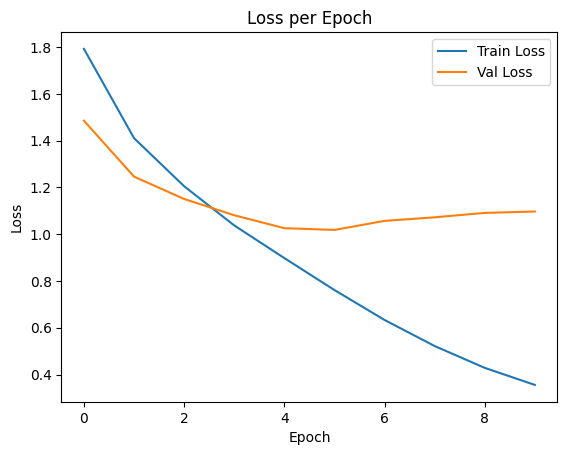

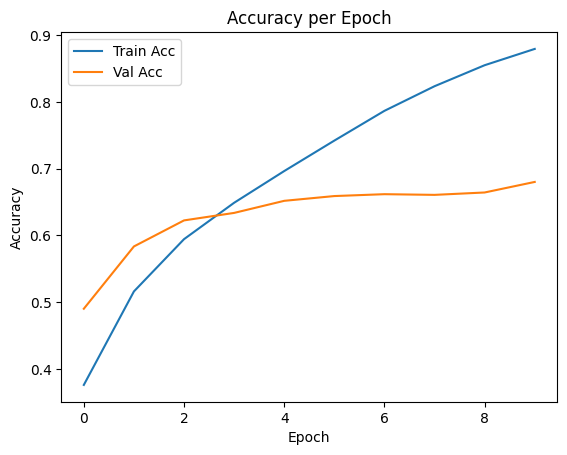

In [9]:
# Plot Loss and Accuracy
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)


In [10]:
# Testing
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        
        test_loss += loss.item() * images_batch.size(0)
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 1.1398, Test Acc: 0.6650
